In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
sns.set_theme()

### Polynomial Regression

In [3]:
x = np.array([-2, 1, 4, 7, 10])
y = np.array([10, 3, 1, 4, 7])

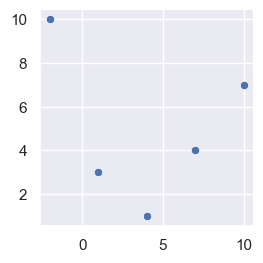

In [4]:
sns.relplot(x=x, y=y, height=3)
plt.show()

In [5]:
from sklearn.preprocessing import PolynomialFeatures

X_poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = X_poly.fit_transform(x.reshape(-1, 1))
X_poly

array([[  1.,  -2.,   4.],
       [  1.,   1.,   1.],
       [  1.,   4.,  16.],
       [  1.,   7.,  49.],
       [  1.,  10., 100.]])

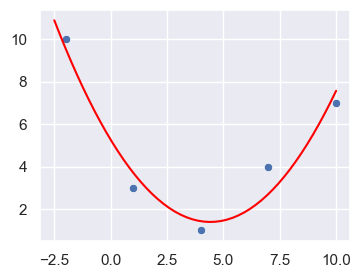

In [6]:
model_poly = LinearRegression(fit_intercept=False).fit(X_poly, y)

x_new = np.linspace(start=-2.5, stop=10, num=50) # 50 support values for polynomial

# transform x_new analogously to the training data
X_new_poly = PolynomialFeatures(degree=2, include_bias=True).fit_transform(x_new.reshape(-1, 1)) 
y_new = model_poly.predict(X_new_poly) # function values of polynomial

fig, ax = plt.subplots(figsize=(4, 3))
sns.scatterplot(ax=ax, x=x, y=y)
sns.lineplot(ax=ax, x=x_new, y=y_new, color="red")
plt.show()


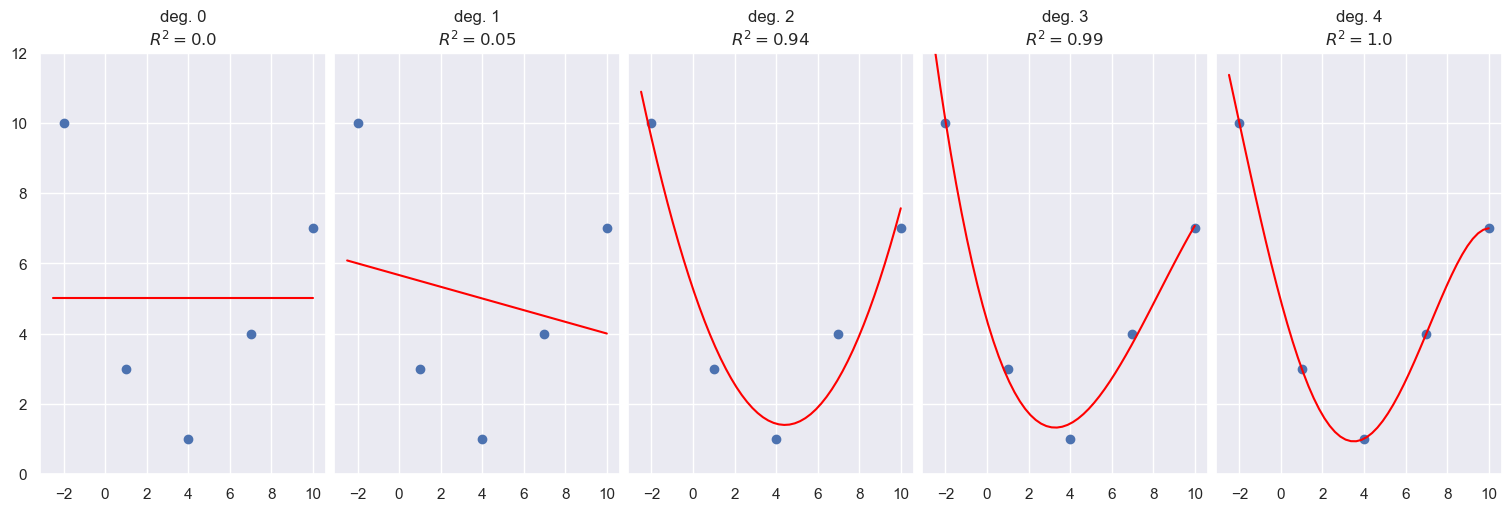

In [7]:
num_models = 5
fig, axs = plt.subplots(1, num_models, sharey =True, figsize=(15, 5), layout = "constrained")

for deg in range(num_models):
    X_poly = PolynomialFeatures(degree = deg, include_bias=True).fit_transform(x.reshape(-1, 1))
    model = LinearRegression(fit_intercept=False).fit(X_poly, y)
    X_new_poly = PolynomialFeatures(degree = deg, include_bias=True).fit_transform(x_new.reshape(-1, 1))
    y_pred = model.predict(X_new_poly)

    axs[deg].scatter(x=x, y=y)
    axs[deg].plot(x_new, y_pred, color = "red")
    axs[deg].set(xticks = [-2, 0, 2, 4, 6, 8, 10], ylim=(0, 12), title="deg. {}\n$R^2={:.2}$".format(deg, model.score(X_poly, y)))
plt.show()

# Model selection

We construct data around a 3rd degree polynomial and fit various polynomials.

### Data generation

In [8]:
def true_function(x):
    return 100*(x-0.2)*(x-0.4)*(x-0.8)

rng = np.random.default_rng(seed=42) # initialize random number generator

x = np.sort(rng.uniform(low=0.0, high=1.0, size=50))
x = x[(x < 0.4) | (x > 0.5)] # cut out some values
y = true_function(x) + 0.8*rng.normal(size=len(x))

# some equidistant support points to plot polynomial curve
x_support = np.linspace(start= x.min(), stop= x.max(), num= 200)
y_true = true_function(x_support)

y_range = y.max()- y.min()
ylim =(y.min() - 0.1*y_range, y.max() + 0.1*y_range)

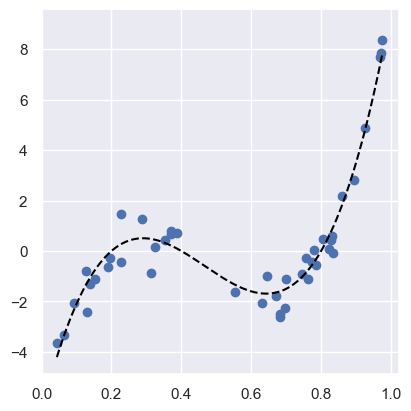

In [9]:
sns.set_theme()
fig, ax = plt.subplots(figsize= (4, 4), layout="constrained")
ax.scatter(x, y)
ax.plot(x_support, y_true, color="black", linestyle="--")
ax.set(ylim=ylim)
plt.show()

### Fit polynomials of various degrees

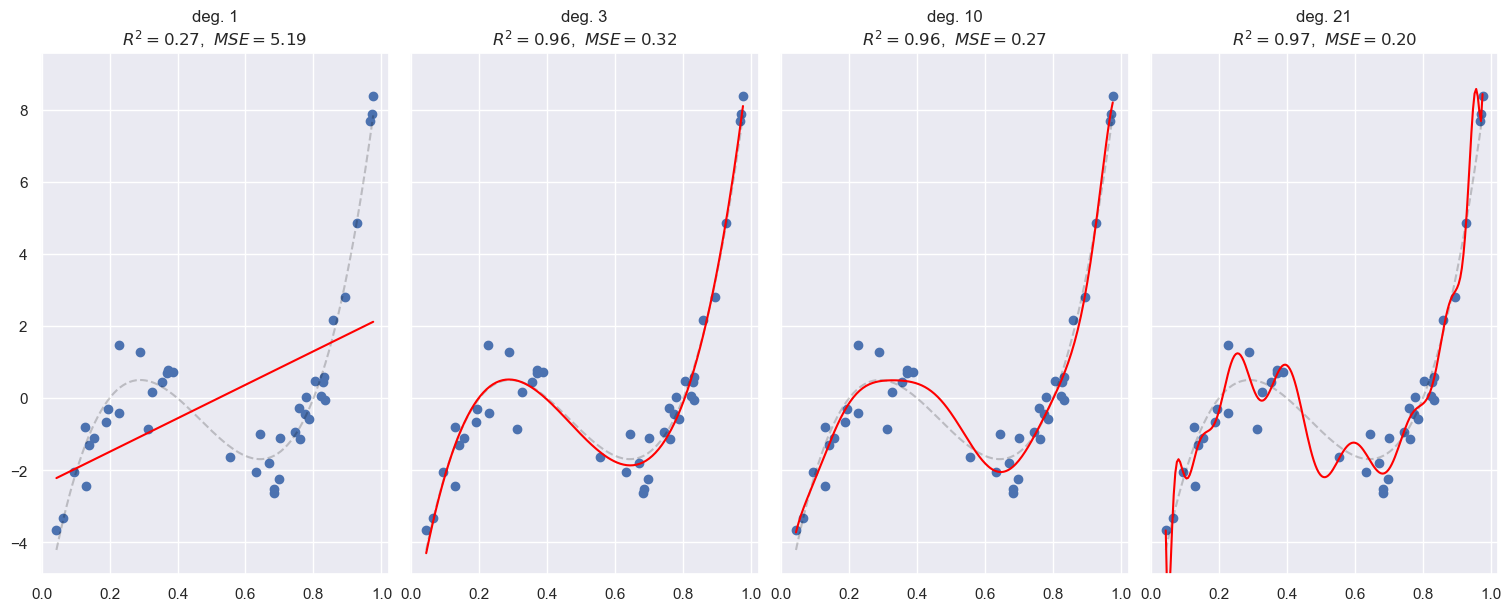

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

degrees = [1, 3, 10, 21] # for these degrees we want to fit models

fig, axs = plt.subplots(1, len(degrees), sharey=True, figsize=(15, 6), layout="constrained")

for degree in range(len(degrees)):
    # Note: LinearRegression() by default adds an intercept (=bias) => For PolynomialFeatures() set parameter include_bias=False
    # also possible: PolynomialFeatures() by default adds a bias => For LinearRegression() set parameter fit_intercept=False
    pipeline = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=degrees[degree], include_bias=False)), 
        ("linear_regression", LinearRegression())
        ])
    
    pipeline.fit(x.reshape(-1, 1), y)
    y_pred = pipeline.predict(x_support.reshape(-1, 1))
    
    R2 = pipeline.score(x.reshape(-1, 1), y)
    MSE = mean_squared_error( y_true= y, y_pred= pipeline.predict(x.reshape(-1, 1)))
    
    axs[degree].scatter(x, y, label="Samples")
    axs[degree].plot(x_support, y_true, color="black", linestyle="--", alpha = 0.2) # Wahrheit
    axs[degree].plot(x_support, y_pred, color="red") # Modell
    axs[degree].set(ylim=ylim, title="deg. {}\n$R^2={:.2}$,  $MSE={:.2f}$".format(degrees[degree], R2, MSE))

plt.show()
fig.savefig("poly_regression_overfitting.png")

### Training and test data sets

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=42)

print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(43,) (43,)
(27,) (27,)
(16,) (16,)


Plot splittet data set

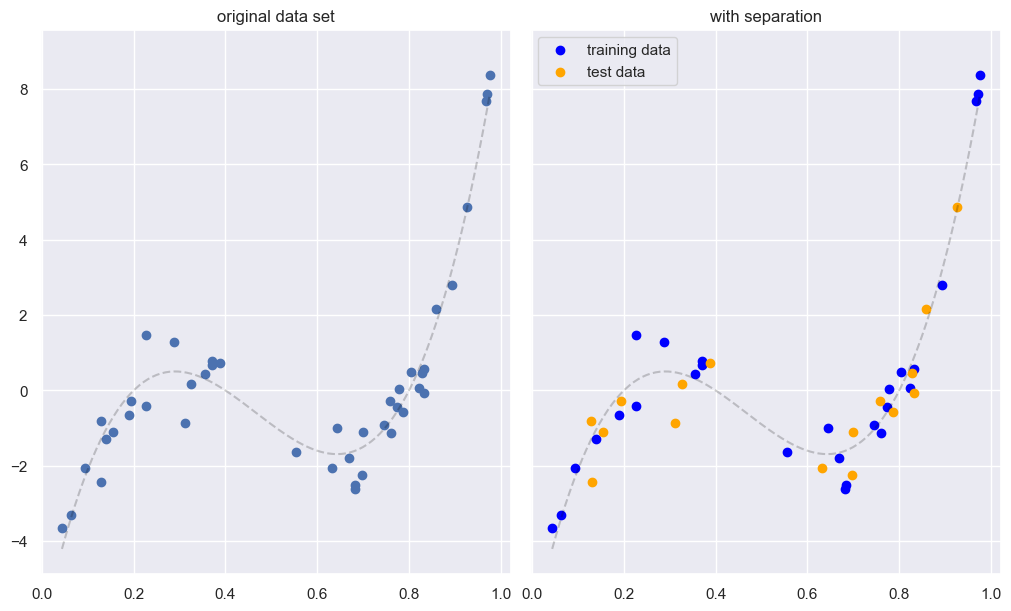

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True, layout="constrained")
axs[0].scatter(x, y)
axs[0].plot(x_support, y_true, color="black", linestyle="--", alpha = 0.2)
axs[0].set(ylim=ylim, title="original data set")

axs[1].scatter(x_train, y_train, color="blue", label="training data")
axs[1].scatter(x_test, y_test, color="orange", label="test data")
axs[1].plot(x_support, y_true, color="black", linestyle="--", alpha = 0.2)
axs[1].set(ylim=ylim, title="with separation")
axs[1].legend()

fig.savefig("split_data.png")
plt.show()

Train the model for some polynomial degrees and evaluate it using test data.

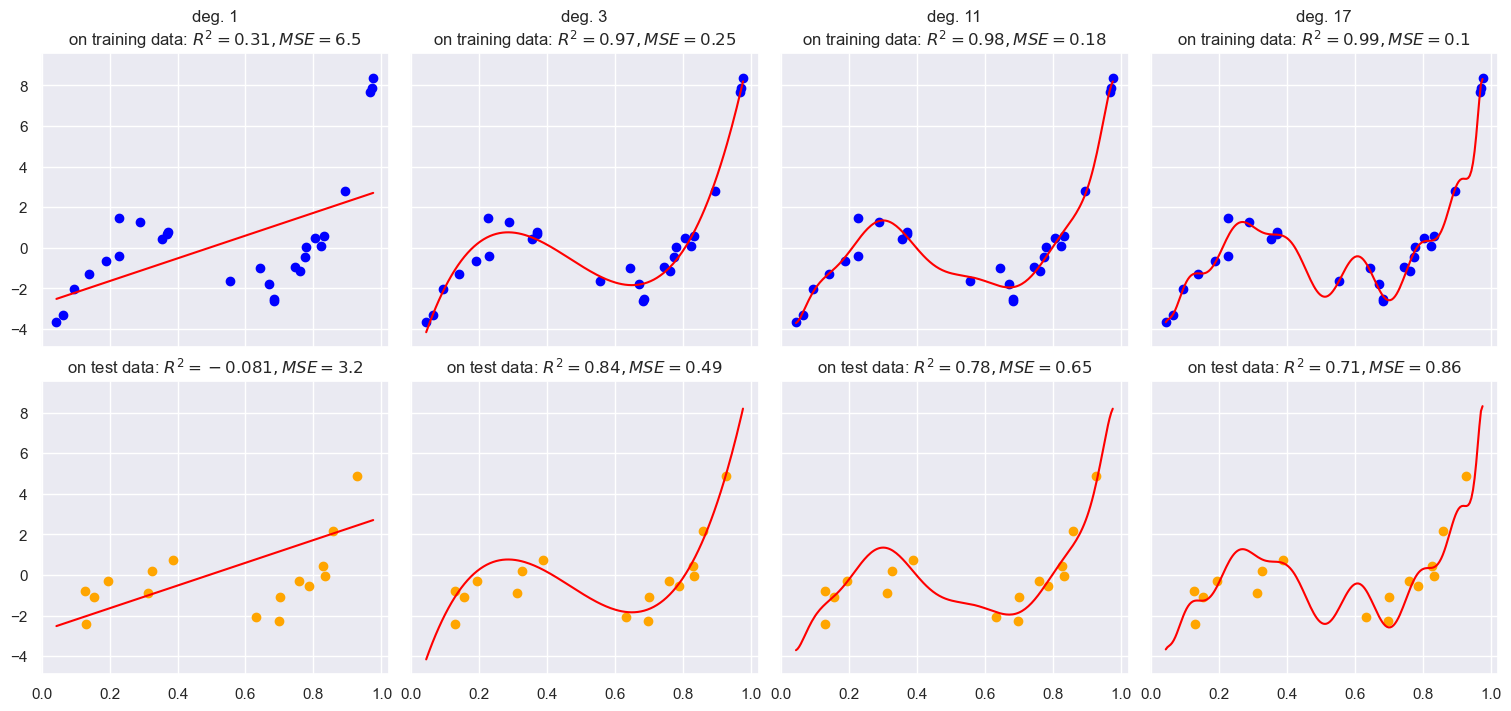

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=42)

degrees = [1, 3, 11, 17]

fig, axs = plt.subplots(2, len(degrees), sharex=True, sharey=True, figsize=(15, 7), layout="constrained")

for degree in range(len(degrees)):
    pipeline = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=degrees[degree], include_bias=False)), 
        ("linear_regression", LinearRegression())
        ])

    pipeline.fit(x_train.reshape(-1, 1), y_train)
    y_pred = pipeline.predict(x_support.reshape(-1, 1))
    
    R2_train  = pipeline.score(x_train.reshape(-1, 1), y_train)
    R2_test   = pipeline.score(x_test.reshape(-1, 1),  y_test)

    MSE_train = mean_squared_error(y_true= y_train, y_pred= pipeline.predict(x_train.reshape(-1, 1)))
    MSE_test  = mean_squared_error(y_true= y_test,  y_pred= pipeline.predict(x_test.reshape(-1, 1)))
    
    # plot training
    axs[0, degree].scatter(x_train, y_train, color="blue", label="training data")
    axs[0, degree].plot(x_support, y_pred, color="red", label="model")
    axs[0, degree].set(ylim=ylim , title="deg. {}\non training data: $R^2={:.2}, MSE={:.2}$".format(degrees[degree], R2_train, MSE_train))

    # plot testing
    axs[1, degree].scatter(x_test, y_test, color="orange", label="test data")
    axs[1, degree].plot(x_support, y_pred, color="red", label="model")
    axs[1, degree].set(ylim=ylim , title="on test data: $R^2={:.2}, MSE={:.2}$".format(R2_test, MSE_test))

plt.show()
fig.savefig("poly_regression_train_test.png")

Now systematically iterate through all polynomial degrees and determine $R^2$ and MSE on the test set.

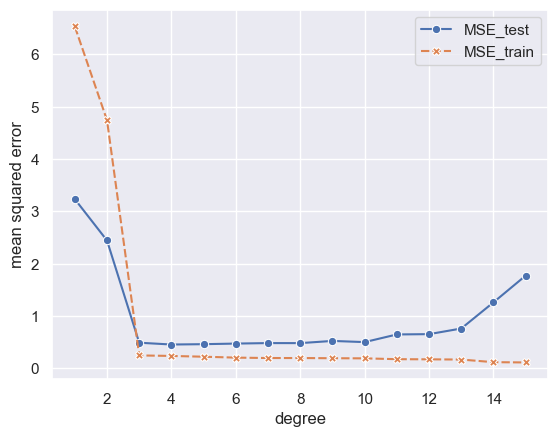

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=42)

scores = []

for degree in range(1, 16):
    pipeline = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=degree, include_bias=False)), 
        ("linear_regression", LinearRegression())
        ])
    
    pipeline.fit(x_train.reshape(-1, 1), y_train)

    MSE_train = mean_squared_error(y_true= y_train, y_pred= pipeline.predict(x_train.reshape(-1, 1)))
    MSE_test  = mean_squared_error(y_true= y_test,  y_pred= pipeline.predict(x_test.reshape(-1, 1)))

    scores.append({"degree": degree, "MSE_train": MSE_train, "MSE_test": MSE_test})

scores_df = pd.DataFrame.from_records(scores).set_index("degree")

fig, ax = plt.subplots()#figsize=(10, 4))
sns.lineplot(ax=ax, data= scores_df[["MSE_test", "MSE_train"]], markers=True)
ax.set_ylabel("mean squared error")
plt.show()

The image above shows that a polynomial degree in the range 2 to 10 would probably be suitable.

However, the actual numerical values of the curve above still depend very much on the respective split in the training and test data.
If an unfavorable split is chosen by chance, the curve can be very noisy.

It is better to repeat the computations several times on different test and training sets, e.g. cross-validation.

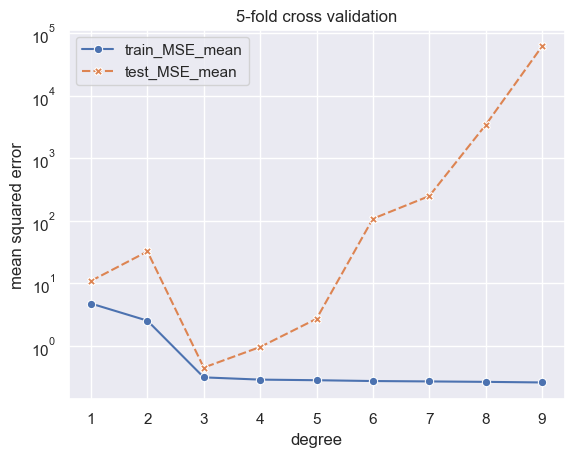

In [15]:
from sklearn.model_selection import cross_validate

scores = []

for degree in range(1, 10):
    pipeline = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=degree, include_bias=False)), 
        ("linear_regression", LinearRegression())
        ])

    cv_scores = cross_validate(
        pipeline, x.reshape(-1,1), y, 
        cv=5, scoring= "neg_mean_squared_error", # alternatively: scoring = "r2"
        return_train_score=True
    )     
    scores.append({"degree": degree, "train_MSE_mean": -np.mean(cv_scores["train_score"]), "test_MSE_mean": -np.mean(cv_scores["test_score"])})

scores_df = pd.DataFrame.from_records(scores).set_index("degree")
scores_df

ax = sns.lineplot(data= scores_df, markers=True)
ax.set(yscale = "log", ylabel="mean squared error", title="5-fold cross validation")
plt.show()

The image above shows that polynomial degree 3 is best.

This is much more convenient with a systematic cross-validated GridSearch over a given set of possible parameters:

In [16]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
        ("polynomial_features", PolynomialFeatures(include_bias=False)), 
        ("linear_regression", LinearRegression())
        ])

parameters = {'polynomial_features__degree': np.arange(1, 10)}
search = GridSearchCV(pipeline, parameters)
search.fit(X= x.reshape(-1,1), y=y)
print(search.best_params_, search.best_score_)

{'polynomial_features__degree': 3} 0.17510508411786008
